In this notebook I'll compute some common information describing the preprocessed data.
1. How many chains are there in general
2. How many structures have small molecule as a ligand?
3. Differences between train/val/test datasets
4. maybe a PCA plot with precomputed embeddings

In [1]:
# !mamba install h5py --update-all

In [2]:
import pandas as pd
import numpy as np
import h5py
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
coordinates_hdf5 = h5py.File("MiSaTo-dataset/data/MD/h5_files/MD.hdf5")
adaptabilities_hdf5 = h5py.File("md_adaptabilities.hdf5")
esm_if_frame0_features_hdf5 = h5py.File("esm_if_out_frame0.hdf5")



In [64]:
def read_split(filename):
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if len(line)==4:
                yield line

train_pdbids_all = list(read_split("MiSaTo-dataset/data/MD/splits/train_MD.txt"))
test_pdbids_all = list(read_split("MiSaTo-dataset/data/MD/splits/test_MD.txt"))
val_pdbids_all = list(read_split("MiSaTo-dataset/data/MD/splits/val_MD.txt"))

train_pdbids = sorted(set(train_pdbids_all) & set(adaptabilities_hdf5.keys()))
test_pdbids = sorted(set(test_pdbids_all) & set(adaptabilities_hdf5.keys()))
val_pdbids = sorted(set(val_pdbids_all) & set(adaptabilities_hdf5.keys()))

print("Train:\t", len(train_pdbids_all), " pdbids \t-->", len(train_pdbids), "pdbids")
print("Test:\t", len(test_pdbids_all), "pdbids \t-->", len(test_pdbids), "pdbids")
print("Val:\t", len(val_pdbids_all), "pdbids \t-->", len(val_pdbids), "pdbids")
print("In total", len(train_pdbids) + len(test_pdbids) + len(val_pdbids), "pdbids")

Train:	 13765  pdbids 	--> 11759 pdbids
Test:	 1612 pdbids 	--> 1352 pdbids
Val:	 1595 pdbids 	--> 1342 pdbids
In total 14453 pdbids


In [65]:
from pathlib import Path
csv_folders = [
    "out_big",
    "out_big_5000",
    "out_big_10000"
]
pdbid2npz_path = dict()
pdbid2csv_path = dict()
for csv_folder in csv_folders:
    csv_folder = Path(csv_folder)
    npz_dir = csv_folder / "npz"
    for npz_file in list(npz_dir.glob("*.npz")):
        pdbid = npz_file.stem
        #if npz_file.exists():
        pdbid2npz_path[pdbid] = npz_file
        csv_file = csv_folder / "pdb" / f"{pdbid}.csv"
        if csv_file.exists():
            pdbid2csv_path[pdbid] = csv_file
        else:
            print(csv_file)
    # break


In [66]:
len(pdbid2csv_path), len(pdbid2npz_path)

(14453, 14453)

In [67]:
lysozyme_pdbids = "1at5 1at6 1f3j 1oba 4hp0 4hpi 4tun 4tun 5lsh".upper().split()

In [68]:
lysozyme_filtered = sorted(set(lysozyme_pdbids) & set(adaptabilities_hdf5.keys()))
lysozyme_filtered

['1AT6', '1F3J', '1OBA', '4HP0', '4HPI', '4TUN', '5LSH']

In [69]:
with h5py.File("lysozyme_data.hdf5", 'w') as f:
    for pdbid in lysozyme_filtered:
        print("   ", pdbid)
        adaptabilities = np.asarray(adaptabilities_hdf5[pdbid])
        group = f.create_group(pdbid)
        group['adaptabilities'] = adaptabilities
        print("adaptabilities", adaptabilities.shape)
        esm_features = np.asarray(esm_if_frame0_features_hdf5[pdbid])
        print("esm_features", esm_features.shape)
        group['esm_if_embeddings'] = esm_features
        trajectory_coordinates = np.asarray(coordinates_hdf5[pdbid]['trajectory_coordinates'])
        group['trajectory_coordinates'] = trajectory_coordinates
        print("trajectory_coordinates", trajectory_coordinates.shape)
        dataset = np.load(pdbid2npz_path[pdbid])
        for key in dataset.keys():
            group[key] = dataset[key]
            print(key, dataset[key].shape)
        # break
    

    1AT6
adaptabilities (100, 127, 3)
esm_features (127, 512)
trajectory_coordinates (100, 2035, 3)
trajectory_coordinates_prepared (100, 127, 3, 3)
atoms_residues (127,)
atoms_chain_numbers (127,)
    1F3J
adaptabilities (100, 766, 3)
esm_features (766, 512)
trajectory_coordinates (100, 12342, 3)
trajectory_coordinates_prepared (100, 766, 3, 3)
atoms_residues (766,)
atoms_chain_numbers (766,)
    1OBA
adaptabilities (100, 338, 3)
esm_features (338, 512)
trajectory_coordinates (100, 5347, 3)
trajectory_coordinates_prepared (100, 338, 3, 3)
atoms_residues (338,)
atoms_chain_numbers (338,)
    4HP0
adaptabilities (100, 128, 3)
esm_features (128, 512)
trajectory_coordinates (100, 2047, 3)
trajectory_coordinates_prepared (100, 128, 3, 3)
atoms_residues (128,)
atoms_chain_numbers (128,)
    4HPI
adaptabilities (100, 128, 3)
esm_features (128, 512)
trajectory_coordinates (100, 2020, 3)
trajectory_coordinates_prepared (100, 128, 3, 3)
atoms_residues (128,)
atoms_chain_numbers (128,)
    4TUN


In [70]:
subset = h5py.File("lysozyme_data.hdf5")
subset['1AT6']['trajectory_coordinates']
subset.close()

In [71]:
data_splits = {
    "train": train_pdbids,
    "test": test_pdbids,
    "val": val_pdbids
}

In [106]:
collected_info = []
pdbid_embeddings = dict()
for name, pdbid_list in data_splits.items():
    print("Processing", name)
    for pdbid in tqdm(pdbid_list):
        df = pd.read_csv(pdbid2csv_path[pdbid])
        has_mol = df.residue_name.apply(lambda x: x=="MOL").any()
        data = {
            "split_name": name,
            "pdbid": pdbid,
            "has_mol": has_mol,
            "nchains": df.chain.value_counts().shape[0],
        }
        last_chain = df.chain.max()
        ligand = df[df.chain == last_chain]
        protein = df[df.chain != last_chain]
        data['protein_total_length'] = protein.shape[0]
        total_CA = protein[protein.atom_name == "CA"].shape[0]
        data['protein_total_length_CA'] = total_CA
        data['protein_chain_lengths_CA'] = list(protein.groupby("chain").apply(lambda row: row[row.atom_name=="CA"].shape[0]).values)
        data['ligand_total_atoms'] = ligand.shape[0]
        data['ligand_CA'] = ligand[ligand.atom_name=="CA"].shape[0]
        esm_if_embeddings = esm_if_frame0_features_hdf5[pdbid][()]
        collected_info.append(data)
        if esm_if_embeddings.shape[0] == protein[protein.atom_name == "CA"].shape[0]:
            mean_embedding = esm_if_embeddings.mean(axis=0)
        else:
            mean_embedding = esm_if_embeddings[:total_CA].mean(axis=0)
        pdbid_embeddings[pdbid] = mean_embedding
        # esm_if_embeddings[]
        # mean_embedding = embeddings.mean(axis=0)
        
        # break
    # break

Processing train


  0%|          | 0/11759 [00:00<?, ?it/s]

Processing test


  0%|          | 0/1352 [00:00<?, ?it/s]

Processing val


  0%|          | 0/1342 [00:00<?, ?it/s]

In [107]:
protein[protein.atom_name == "CA"].shape

(828, 7)

In [108]:
misato_info_df = pd.DataFrame(collected_info)

In [109]:
lysozyme_filtered

['1AT6', '1F3J', '1OBA', '4HP0', '4HPI', '4TUN', '5LSH']

In [102]:
# df.residue_name.apply(lambda x: x=="MOL").any()


In [111]:
misato_info_df[misato_info_df.pdbid.isin(lysozyme_filtered)]

,split_name,pdbid,has_mol,nchains,protein_total_length,protein_total_length_CA,protein_chain_lengths_CA,ligand_total_atoms,ligand_CA
335,train,1F3J,False,6,12113,752,"[182, 187, 14, 182, 187]",229,14
11771,test,1AT6,True,2,1951,127,[127],84,0
12415,test,4HP0,True,2,1941,128,[128],106,0
12416,test,4HPI,True,2,1941,128,[128],79,0
12564,test,4TUN,True,2,1960,129,[129],26,0
12760,test,5LSH,True,2,2021,130,[130],96,0
13226,val,1OBA,True,2,5326,338,[338],21,0


In [115]:
misato_info_df[misato_info_df.protein_total_length_CA == 128]
# we can try to draw one of the selected lysosyme proteins with this subset of molecules later

,split_name,pdbid,has_mol,nchains,protein_total_length,protein_total_length_CA,protein_chain_lengths_CA,ligand_total_atoms,ligand_CA
2276,train,2LSP,True,2,2050,128,[128],239,0
4014,train,3JVK,True,2,2122,128,[128],53,0
4747,train,3RDO,True,4,1826,128,"[1, 3, 124]",31,0
5828,train,4DRK,True,2,1984,128,[128],82,0
5829,train,4DRM,True,2,1984,128,[128],90,0
5830,train,4DRN,True,2,1984,128,[128],90,0
5831,train,4DRO,True,2,1984,128,[128],84,0
5832,train,4DRP,True,2,1984,128,[128],90,0
6379,train,4JFJ,True,2,1984,128,[128],65,0
6380,train,4JFK,True,2,1984,128,[128],66,0


In [118]:
misato_info_df.groupby("split_name").agg(
    {
        "has_mol": 'count'
    }
)

,has_mol
split_name,
test,1352
train,11759
val,1342


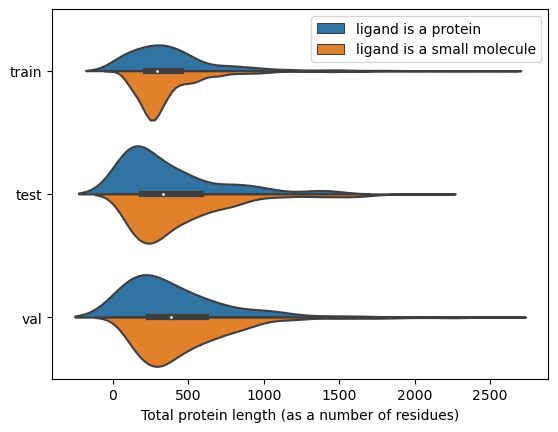

In [156]:
import seaborn as sns
ax = sns.violinplot(misato_info_df, y="split_name", x="protein_total_length_CA", hue="has_mol",
                    split=True
                    )#, legend=["ligand is a small molecule", "ligand is a peptide"])
ax.set_xlabel("Total protein length (as a number of residues)")
ax.set_ylabel("")
# ax.legend(off=True)
legend = ax.legend()
legend.get_texts()[0].set_text("ligand is a protein")
legend.get_texts()[1].set_text("ligand is a small molecule")

# ax.legend()
